# COMP90051 Project 2

Haonan Zhong 867492

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Optional, Tuple, Callable

from sklearn.linear_model import LogisticRegression  # for Part 4

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Parts 1-4 should inherit from this class.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
    
    @abstractmethod
    def play(self, context: Optional[ndarray] = None) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        pass
    
    @abstractmethod
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
            
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
        """
        if not isinstance(arm, (int, np.integer)):
            raise TypeError("`arm` must be an int")
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range [0, {}]".format(self.n_arms - 1))
        if not isinstance(reward, (int, np.integer, float, np.float64)):
            raise TypeError("`reward` must be a numeric scalar")                       

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Parts 1-4.

In [3]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if n_rounds is not None and matched_ctr >= n_rounds: # Note: fixed
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, reward, contexts[i])
            matched_ctr += 1
            matched_ids.append(i)
    
    return rewards[matched_ids], matched_ids

In [55]:
def plot_results(results, label=None):
    """Plot pre-round cumulative reward of a given reward list
    
    Parameters
    ----------
    results : ndarray
        Rewards

    Returns
    -------
    None
    """
    tround = np.arange(1, results.size + 1)
    cumsum = np.cumsum(results)/tround
    plt.plot(tround, cumsum, label=label, linewidth=0.8)

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [287]:
rng = np.random.default_rng(90051)  # Random generator used throughout

# Define additional static functions/variables here, if required
def merit_function(x, c):
    return np.exp(c * x)

Load dataset

In [6]:
file_path = "../code/dataset.txt"

arms, rewards, features = [], [], []
event_count = 0
data = open(file_path, 'r')

for line in data:
    event_count += 1
    cols = line.split()
    arms.append(int(cols[0]))
    rewards.append(float(cols[1]))

    feature = cols[2:]
    feature = [float(element) for element in feature]
    features.append(feature)


arms = np.array(arms)
rewards = np.array(rewards)
features = np.array(features)
# reshape the context of each event into the required size
contexts = features.reshape(event_count, 10, 10)

## Part 1: Thompson sampling MAB

In [542]:
class TS(MAB):
    """Thompson sampling MAB with a Beta-Bernoulli reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.

    alpha0: float, optional
        positive real prior hyperparameter

    beta0: float, optional
        positive real prior hyperparameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, alpha0: float = 1.0, beta0: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        self.alpha0 = float(alpha0)
        self.beta0 = float(beta0)

        if self.alpha0 <= 0 or self.beta0 <= 0:
            raise ValueError("`beta` and `alpha` must be greater than 0")

        self.S = np.full(self.n_arms, self.alpha0, dtype=float)
        self.F = np.full(self.n_arms, self.beta0, dtype=float)
        
    def play(self, context: Optional[ndarray] = None) -> int:
        super().play()
        # Compute theta for each arm
        theta = self.rng.beta(self.S, self.F)
        # Find the arm with the maximum theta, tie break if there are multiple
        max_arm = self.rng.choice(np.argwhere(theta==theta.max()).flatten())
        return max_arm
        
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        super().update(arm, reward)

        if reward == 1:
            self.S[arm] += 1
        elif reward == 0:
            self.F[arm] += 1
        else:
            raise ValueError("`reward` should be a positive integer with value either 0 or 1") 

In [543]:
mab = TS(10, alpha0=1.0, beta0=1.0, rng=rng)
TS_rewards, TS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('TS average reward', np.mean(TS_rewards))

TS average reward 0.2075


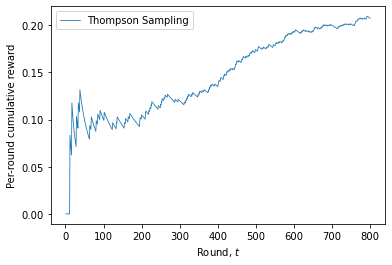

In [544]:
plot_results(TS_rewards, label="Thompson Sampling")
plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

Tuning the value of $\alpha_0$ and $\beta_0$

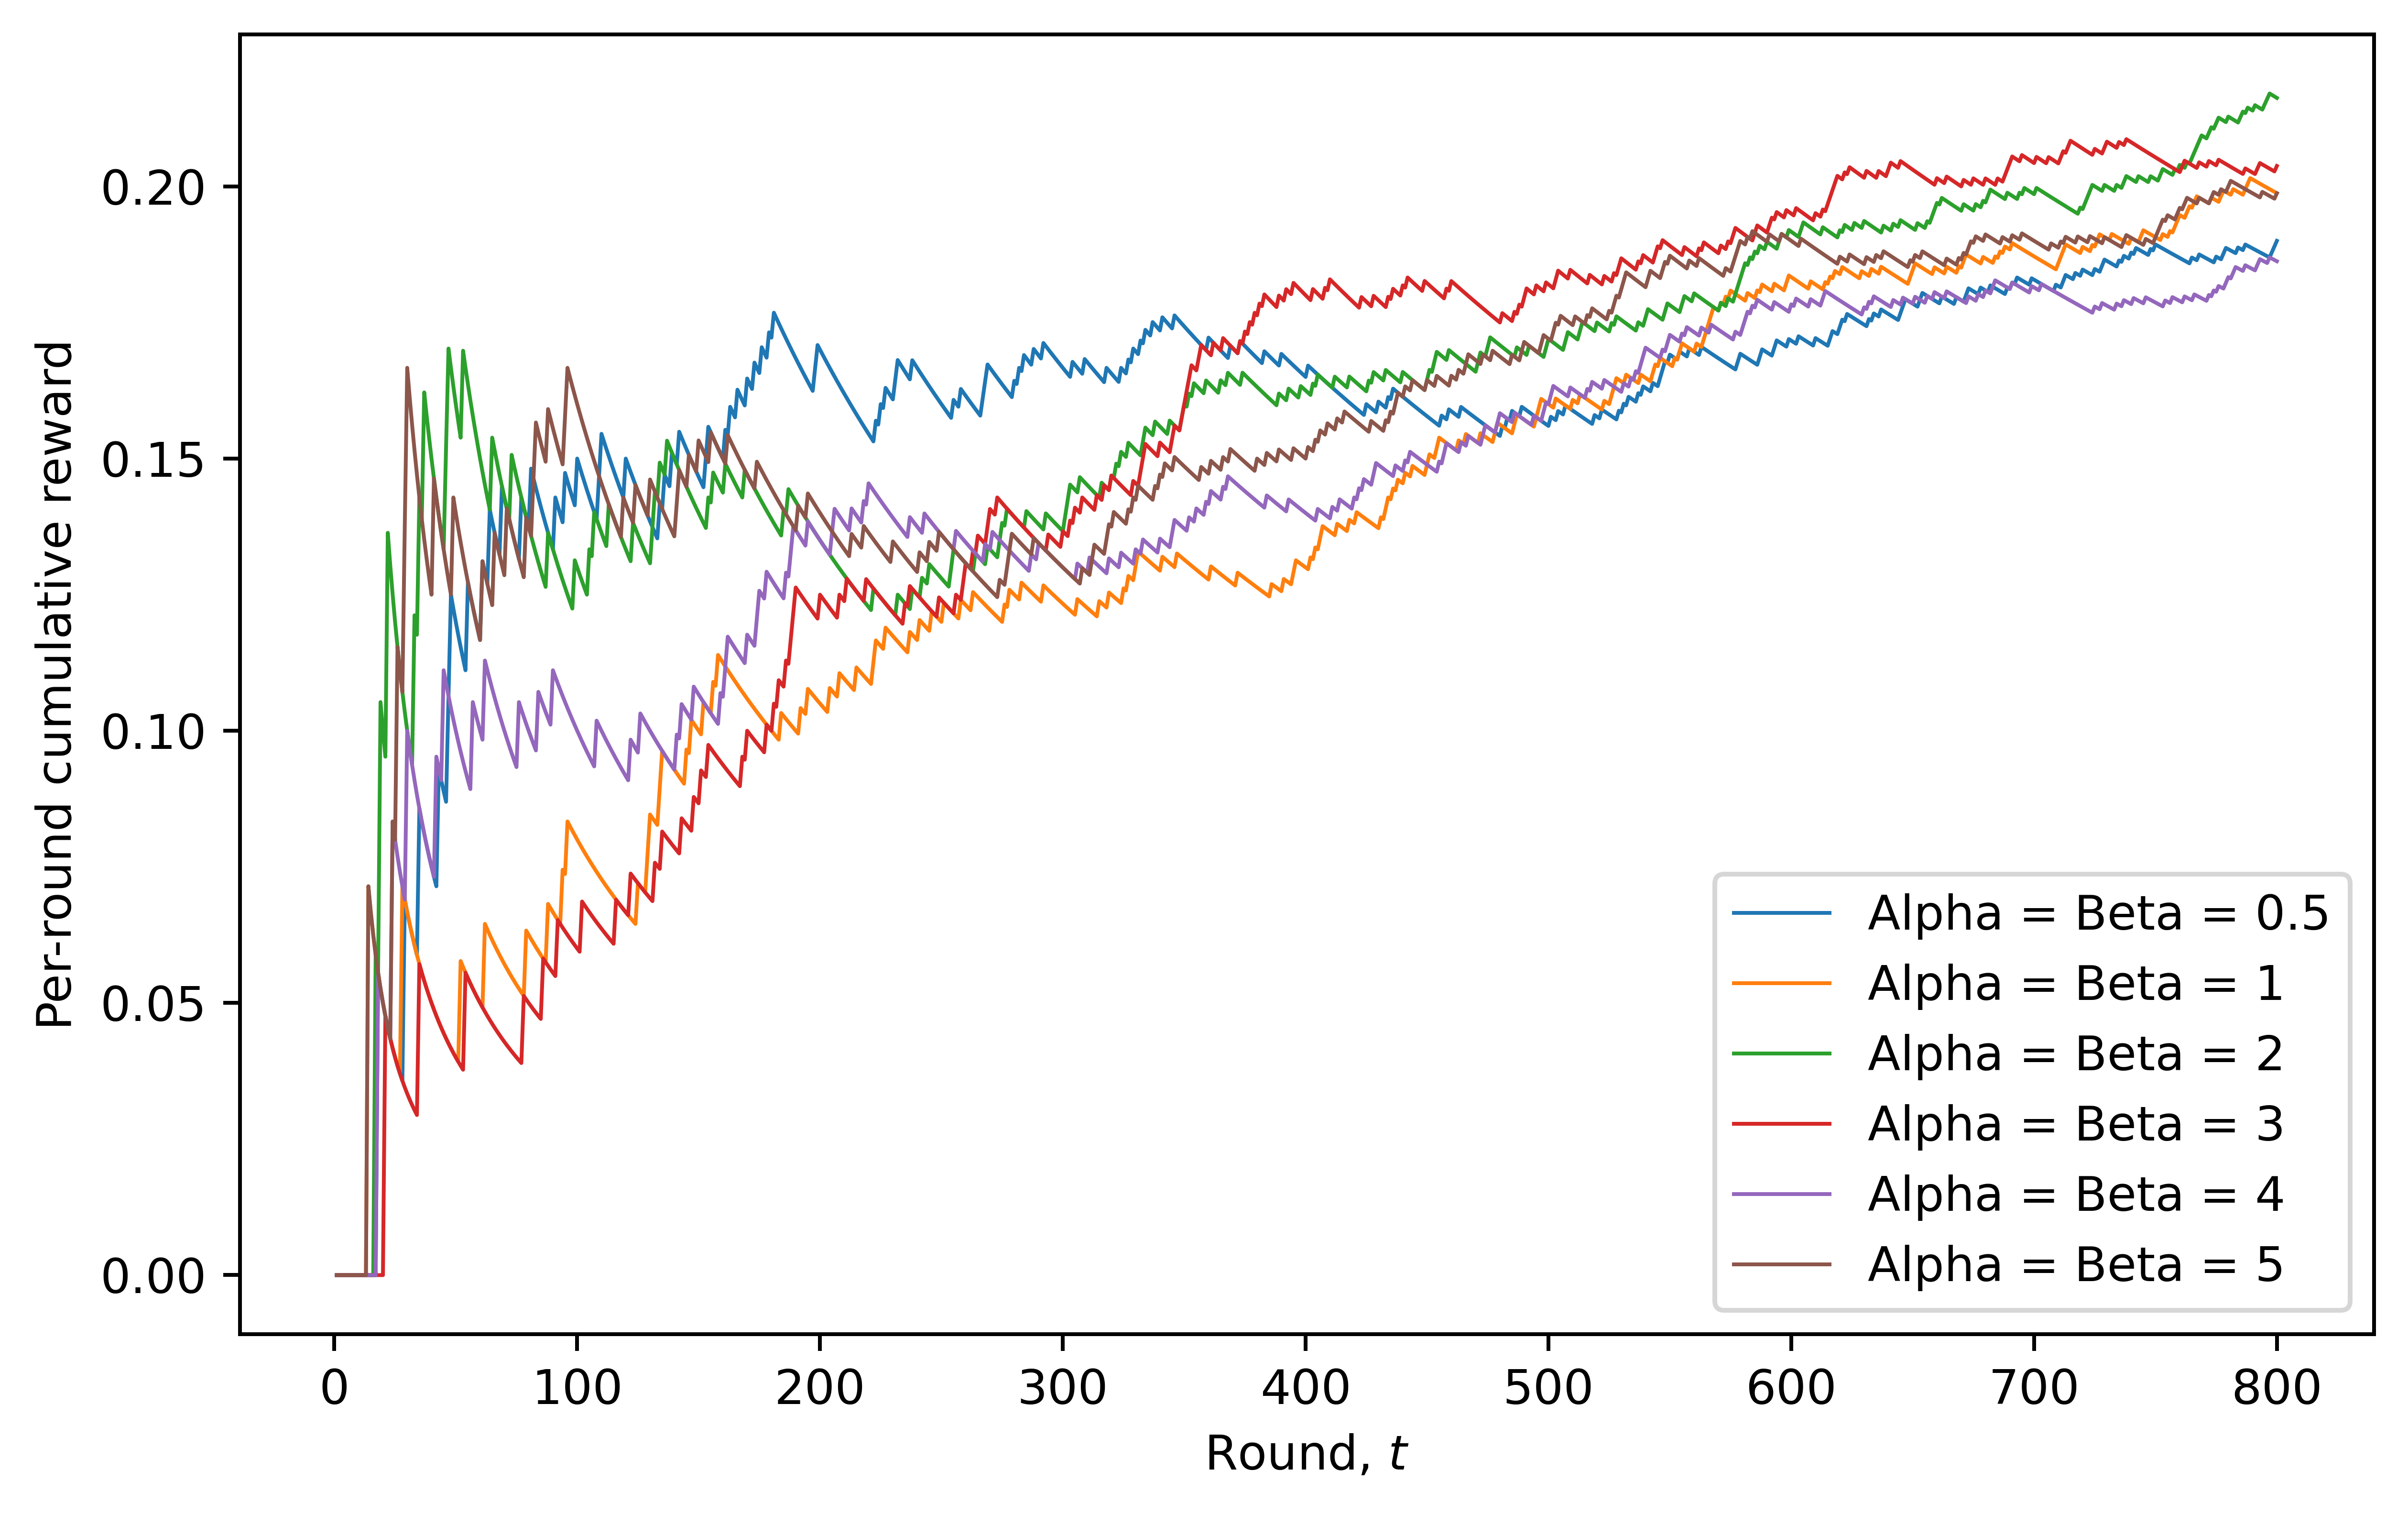

In [548]:
candidate = [0.5, 1, 2, 3, 4, 5]
plt.figure(figsize=(8,5), dpi=720)
for i in candidate:
    mab = TS(10, alpha0=i, beta0=i, rng=rng)
    tune_rewards, ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
    plot_results(tune_rewards, label="Alpha = Beta = " + str(i))

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

## Part 2: Thompson sampling contextual MAB with linear payoffs

In [549]:
class LinTS(MAB):
    """Thompson sampling contextual MAB with a ridge regression reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.
    
    n_dims : int
        Number of dimensions for each arm's context.
        
    v: float, optional
        Positive real explore-exploit parameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """    
    def __init__(self, n_arms: int, n_dims: int, v: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        self.n_dims = int(n_dims)
        self.v = float(v)

        if self.n_dims < 0:
            raise ValueError("`n_dims` must be greater or equal 0")
        if self.v <= 0:
            raise ValueError("`v` must be a positive real number")

        self.B = np.identity(self.n_dims)
        self.mu_hat = np.zeros(self.n_dims)
        self.f = np.zeros(self.n_dims)
        
    def play(self, context: Optional[ndarray] = None) -> int:
        # sample mu_t from multivariate normal distribution
        sample_mu = self.rng.multivariate_normal(self.mu_hat, \
            np.dot(np.square(self.v), np.linalg.inv(self.B)))
        
        # compute the estimate and find arm with maximum value, if there's multiple break tie randomly
        est = np.array([np.dot(context[i].T, sample_mu) for i in range(self.n_arms)])
        max_arm = self.rng.choice(np.argwhere(est == est.max()).flatten())
        
        return max_arm

    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        super().update(arm, reward)
        
        #self.B += np.dot(context[arm].T, context[arm]) # Update B
        #self.f += np.dot(context[arm], reward) # Update f
        #self.mu_hat = np.dot(np.linalg.inv(self.B), self.f) # Update mu_hat
        b_att = context[arm].reshape(self.n_dims, 1)
        self.B += np.dot(b_att, b_att.T)
        self.f += np.dot(b_att, reward).reshape(self.n_dims)
        self.mu_hat = np.dot(np.linalg.inv(self.B), self.f.reshape(self.n_dims, 1)).reshape(self.n_dims)

In [554]:
mab = LinTS(10, 10, v=0.5, rng=rng)
LinTS_rewards, LinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('LinTS average reward', np.mean(LinTS_rewards))

LinTS average reward 0.385


Plot per-round cumulative reward for TS and LinTS on the same set of axes

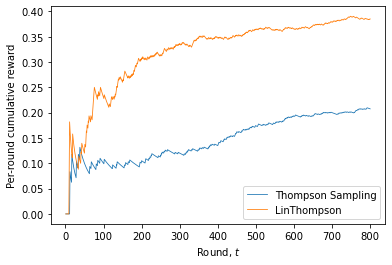

In [555]:
plot_results(TS_rewards, label="Thompson Sampling")
plot_results(LinTS_rewards, label="LinThompson")
plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

Tuning the value of $v$

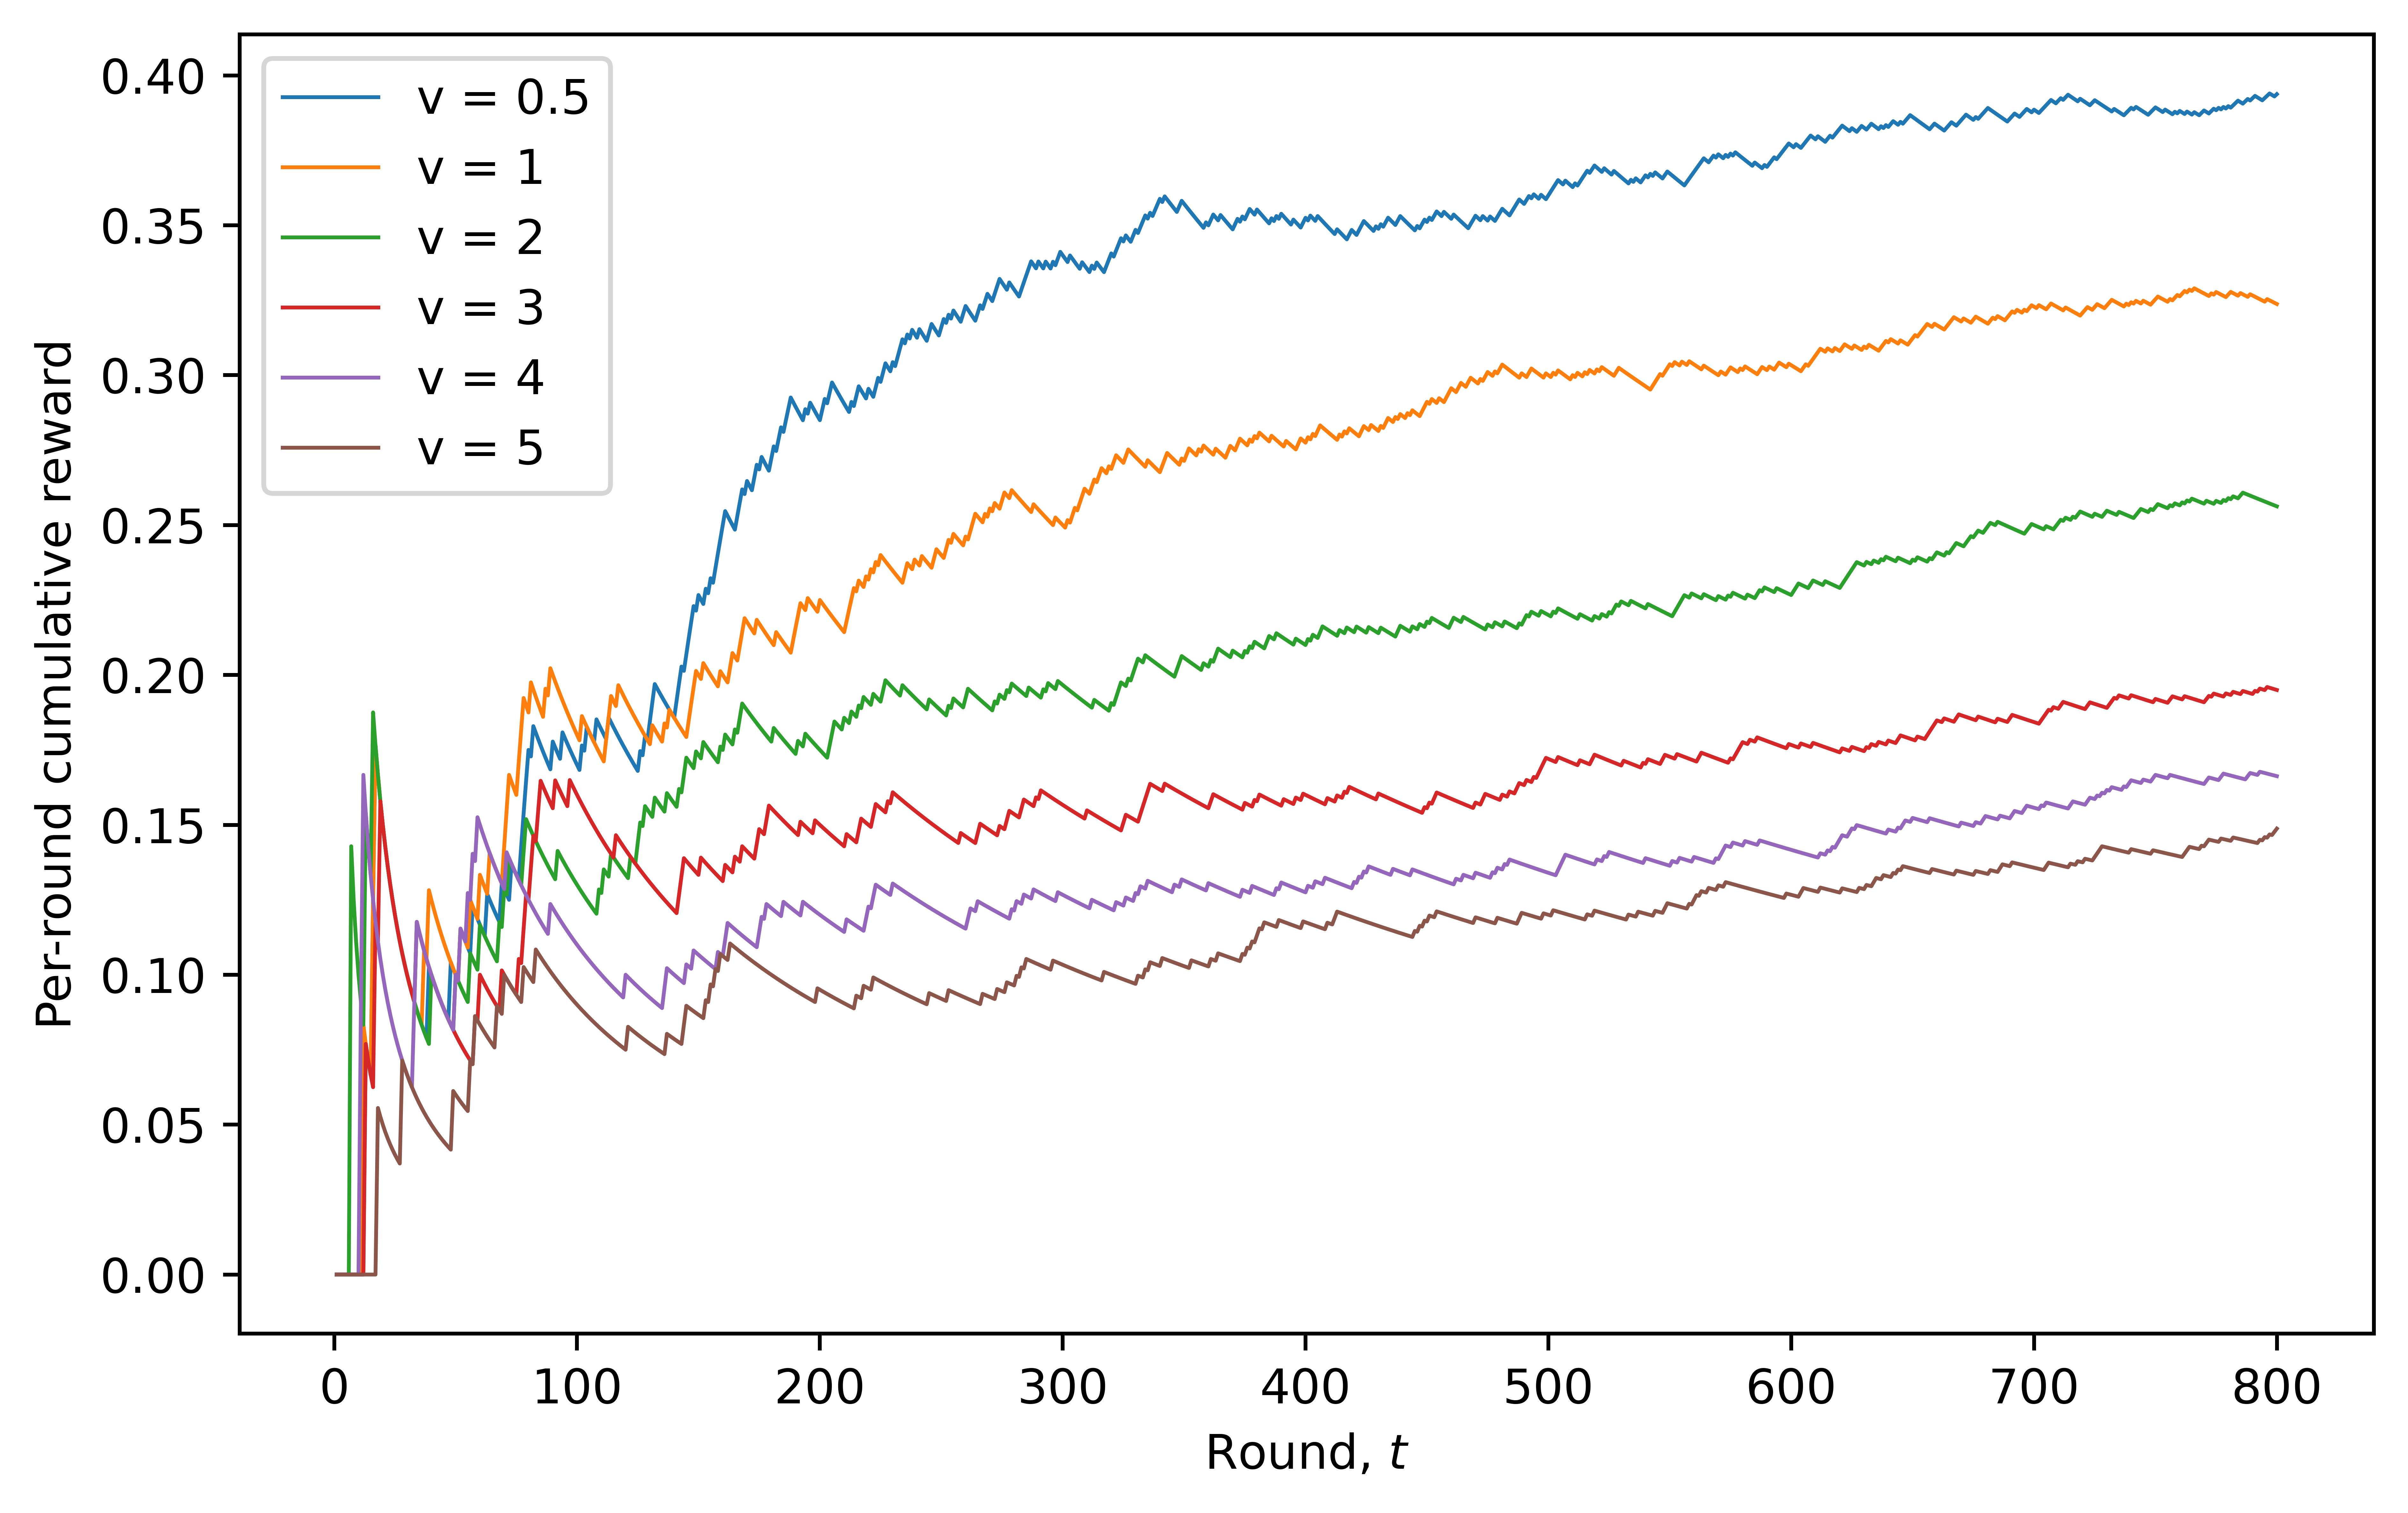

In [552]:
candidate = [0.5, 1, 2, 3, 4, 5]
plt.figure(figsize=(8,5), dpi=1080)
for i in candidate:
    mab = LinTS(10, 10, v=i, rng=rng)
    tune_rewards, ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
    plot_results(tune_rewards, label="v = " + str(i))

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

## Part 3: Thompson sampling MABs with fair exposure

In [556]:
class FairXTS(MAB):
    """FairX Thompson sampling MAB with a Beta-Bernoulli reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.

    c : float, optional
        Scaling factor for expected reward in exponential merit function
    
    alpha0: float, optional
        Positive real prior hyperparameter.

    beta0: float, optional
        Positive real prior hyperparameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, c: float = 1.0, alpha0: float = 1.0, 
                 beta0: float = 1.0, rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        self.alpha0 = float(alpha0)
        self.beta0 = float(beta0)
        self.c = float(c)

        if self.alpha0 <= 0 or self.beta0 <= 0:
            raise ValueError("`beta` and `alpha` must be greater than 0")

        self.S = np.full(self.n_arms, self.alpha0, dtype=float)
        self.F = np.full(self.n_arms, self.beta0, dtype=float)
    
    def play(self, context: Optional[ndarray] = None) -> int:
        mu_t = self.rng.beta(self.S, self.F)
        policy_numerator = np.exp(np.array(mu_t) * self.c)
        pi_t = policy_numerator/sum(policy_numerator)

        #sampling = np.array(self.rng.multinomial(1, pi_t))
        return self.rng.choice([arm for arm in range(10)], p=pi_t)
            #np.argwhere(sampling == sampling.max()).flatten())
        
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        super().update(arm, reward)
        
        if reward == 1:
            self.S[arm] += 1
        elif reward == 0:
            self.F[arm] += 1
        else:
            raise ValueError("`reward` should be a positive integer has value either 0 or 1") 
        

In [577]:
mab = FairXTS(10, c=0.5, alpha0=1.0, beta0=1.0, rng=rng)
FairXTS_rewards, FairXTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-TS average reward', np.mean(FairXTS_rewards))

FairX-TS average reward 0.11625


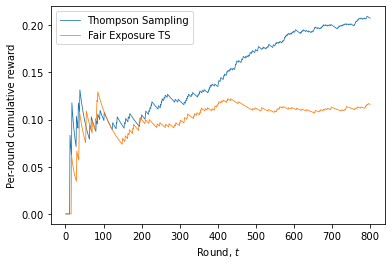

In [578]:
# Use additional cells here for experimentation
plot_results(TS_rewards, label="Thompson Sampling")
plot_results(FairXTS_rewards, label="Fair Exposure TS")
plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

In [562]:
TS_arms = [arms[i] for i in TS_ids]
FairXTS_arms = [arms[i] for i in FairXTS_ids]
TS_count = []
FairXTS_count = []
arm_list = [i for i in range(10)]
for i in range(10):
    TS_count.append(TS_arms.count(i))
    FairXTS_count.append(FairXTS_arms.count(i))

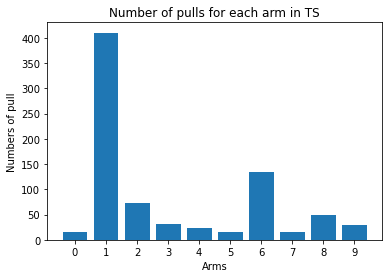

In [579]:
plt.bar(arm_list, TS_count)
plt.xticks(arm_list)
plt.xlabel('Arms')
plt.ylabel('Numbers of pull')
plt.title('Number of pulls for each arm in TS')
plt.show()

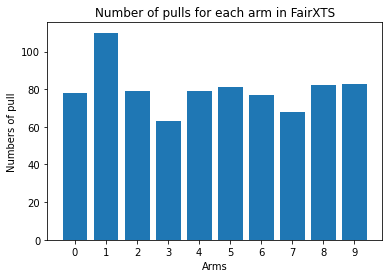

In [580]:
plt.bar(arm_list, FairXTS_count)
plt.xticks(arm_list)
plt.xlabel('Arms')
plt.ylabel('Numbers of pull')
plt.title('Number of pulls for each arm in FairXTS')
plt.show()

When comparing the number of pulls for each arm between the two, the number of pulls for each arm are more uniformly distributed in Fair Exposure TS, while in TS the pulls for heavily focused on one arm. The difference are due to the basic Thompson Sampling adopts the winner-takes-all allocation, while Fair Exposure TS allows each arm receives a certain amount of exposure proportional to its merit, and explore more.

In [581]:
class FairXLinTS(MAB):
    """FairX Thompson sampling contextual MAB with a ridge regression reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.
    
    n_dims : int
        Number of dimensions for each arm's context.
    
    c : float, optional
        Scaling factor for expected reward in exponential merit function
    
    v: float, optional
        Positive real explore-exploit parameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, c: float = 1.0, 
                 v: float = 1.0, rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        self.n_dims = int(n_dims)
        self.v = float(v)

        if self.n_dims < 0:
            raise ValueError("`n_dims` must be greater or equal 0")
        if self.v <= 0:
            raise ValueError("`v` must be a positive real number")

        self.B = np.identity(self.n_dims)
        self.mu_hat = np.zeros(self.n_dims)
        self.f = np.zeros(self.n_dims)
        self.c = c
    
    def play(self, context: Optional[ndarray] = None) -> int:
        # sample mu_t from multivariate normal distribution
        sample_mu = self.rng.multivariate_normal(self.mu_hat, \
            (self.v**2) * np.linalg.inv(self.B))
            
        est = np.array([np.dot(sample_mu, context[i]) for i in range(self.n_arms)])
        score = [merit_function(x, self.c) for x in est]
        pi_t = np.array(score)/sum(score)
        #sampling = np.array(self.rng.multinomial(1, pi_t))

        return self.rng.choice([arm for arm in range(10)], p=pi_t)
    
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        super().update(arm, reward)

        b_att = context[arm].reshape(self.n_dims, 1)
        self.B += np.dot(b_att, b_att.T)
        self.f += np.dot(b_att, reward).reshape(self.n_dims)
        self.mu_hat = np.dot(np.linalg.inv(self.B), self.f.reshape(self.n_dims, 1)).reshape(self.n_dims,)

In [583]:
mab = FairXLinTS(10, 10, c=1.0, v=0.5, rng=rng)
FairXLinTS_rewards, FairXLinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-LinTS average reward', np.mean(FairXLinTS_rewards))

FairX-LinTS average reward 0.13625


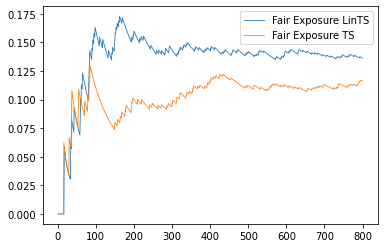

In [584]:
plot_results(FairXLinTS_rewards, label="Fair Exposure LinTS")
plot_results(FairXTS_rewards, label="Fair Exposure TS")
plt.legend()
plt.show()

## Task 4: SquareCB contextual MAB with a logistic regression oracle

In [530]:
class SquareCB(MAB):
    """SquareCB contextual MAB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float, optional
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)

        self.n_dims = n_dims
        self.gamma = gamma
        self.mu = n_arms  # hard-code parameter μ to be the number of arms

        if self.n_dims < 0:
            raise ValueError("`n_dims` must be greater or equal 0")
        if self.gamma <= 0:
            raise ValueError("`gamma` must be greater than 0")

        self.contexts = [[] for i in range(self.n_arms)]  # initialise contexts for arms
        self.rewards = [[] for i in range(self.n_arms)]   # initialise rewards for arms
        self.models = [LogisticRegression() for i in range(self.n_arms)] # initialise a model for each arm
        self.arm_played = [False for i in range(self.n_arms)] 
    
    def play(self, context: Optional[ndarray] = None) -> int:
        scores = np.zeros(self.n_arms)

        for i in range(self.n_arms):
            # if an arm only has one class, randomly assign a value between 0 and 1
            # since we won't be able to train logistic regression with one class
            if self.arm_played[i] == False:
                scores[i] = self.rng.uniform(0,1)
            else:
                scores[i] = self.models[i].predict_proba(np.asarray(context[i]).reshape(1, -1))[0][0]
        b_t_index = self.rng.choice(np.argwhere(scores == scores.min()).flatten())
        b_t = scores[b_t_index]

        p_t = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            if i != b_t_index:
                p_t[i] = 1 / (self.mu + self.gamma * (scores[i] - b_t))

        p_t[b_t_index] = 1 - sum(p_t)
        return self.rng.choice([arm for arm in range(10)], p=p_t)
    
    def update(self, arm: int, reward: float, 
               context: Optional[ndarray] = None) -> None:

        self.contexts[arm].append(context[arm].flatten())
        self.rewards[arm].append(reward)
        full_reward = [i for i in self.rewards[arm]]

        # check if there's two class for rewards
        # since logistic regression needs to have two class to operate
        # fit the model is condition satisfied
        if len(set(full_reward)) == 2:
            self.arm_played[arm] = True
            self.models[arm].fit(np.asarray(self.contexts[arm]), np.asarray(self.rewards[arm]))
        

In [533]:
mab = SquareCB(10, 10, gamma=18.0, rng=rng)
SquareCB_rewards, SquareCB_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('SquareCB average reward', np.mean(SquareCB_rewards))

SquareCB average reward 0.53


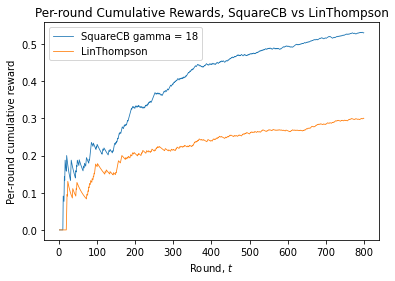

In [541]:
plot_results(SquareCB_rewards, label="SquareCB gamma = 18")
plot_results(LinTS_rewards, label="LinThompson")
plt.legend()
plt.title('Per-round Cumulative Rewards, SquareCB vs LinThompson')
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

Tuning the value of $\gamma$

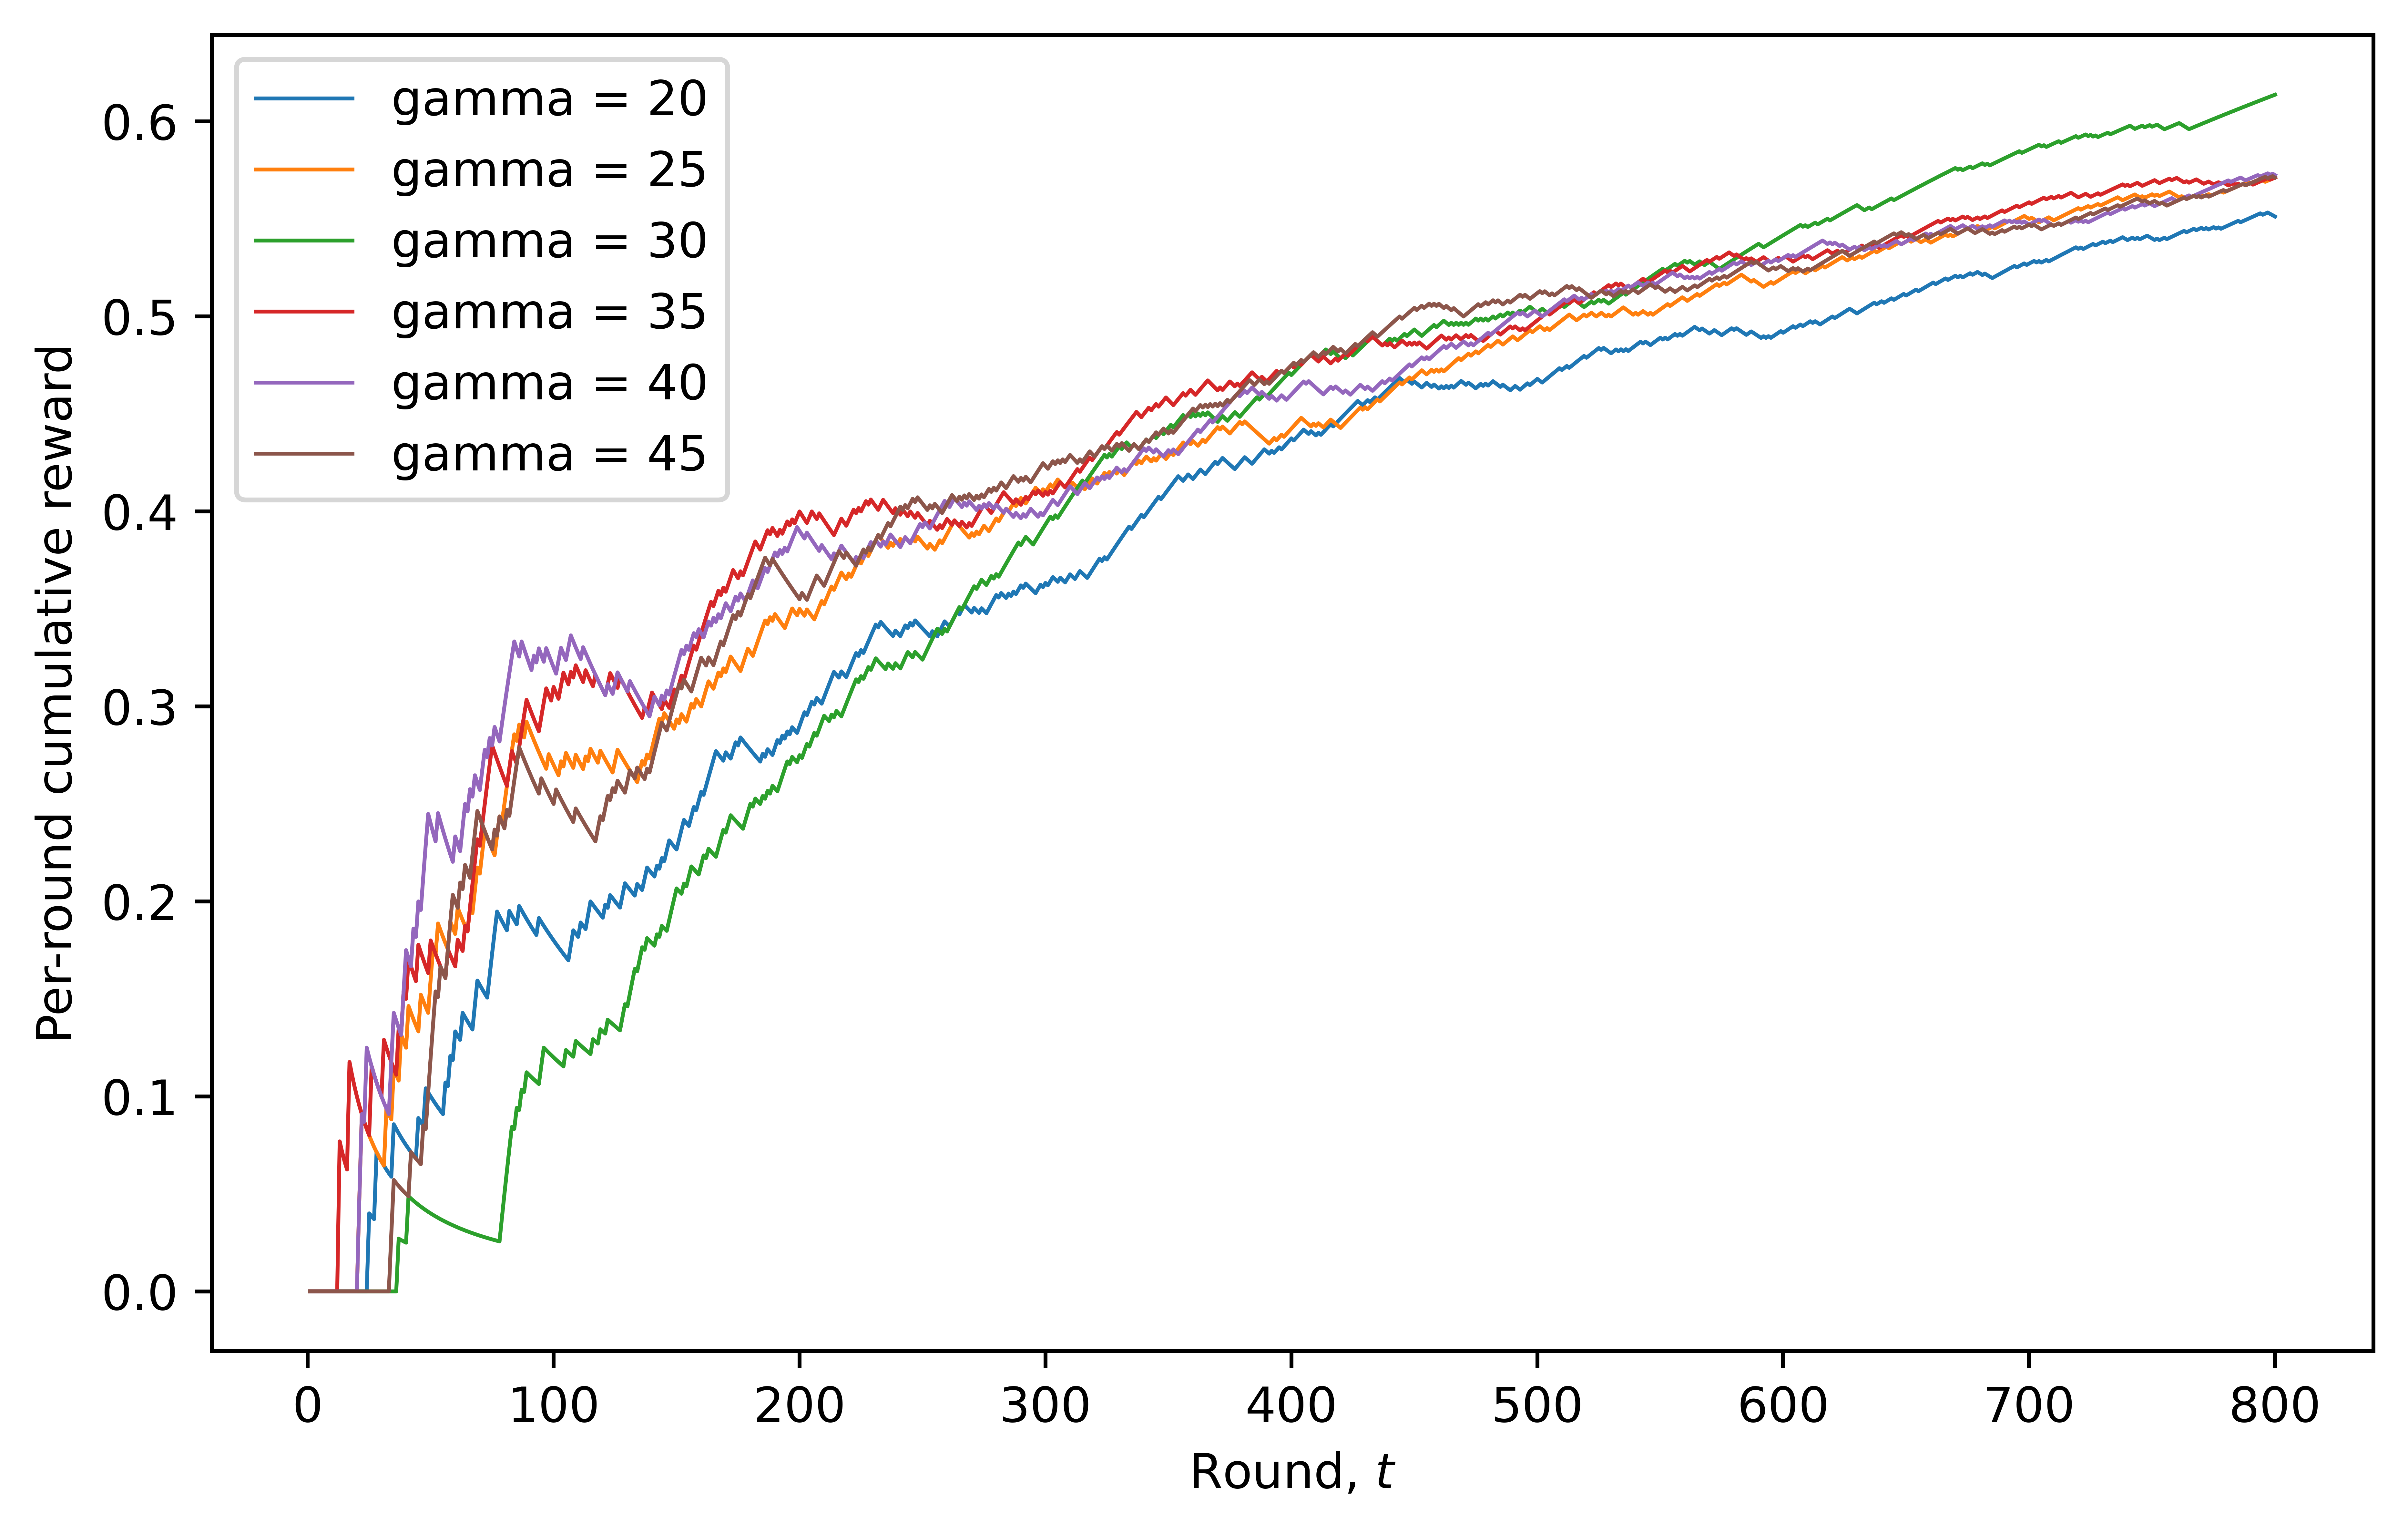

In [539]:
gamma_candidate = [20, 25, 30, 35, 40, 45]
plt.figure(figsize=(8,5), dpi=1080)
for i in gamma_candidate:
    mab = SquareCB(10, 10, gamma=i, rng=rng)
    tune_rewards, ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
    plot_results(tune_rewards, label="gamma = " + str(i))

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()